In [ ]:
# Harris Corner Detector

import numpy as np
import cv2
from scipy.ndimage import sobel, gaussian_filter, maximum_filter


# =============================================================================
#                          HARRIS CORNER DETECTOR
# =============================================================================

def harris_corners_from_scratch(
    image,
    k=0.04,
    threshold_ratio=0.01,
    sigma=1.5,
    nms_size=3,
):
    """
    Harris Corner Detector (safe & improved).

    Returns:
        corners : list[(y, x)]
        R       : response map
    """

    # --------------------------------------------------
    # Ensure grayscale
    # --------------------------------------------------
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    gray = gray.astype(np.float32)

    # --------------------------------------------------
    # Gradients
    # --------------------------------------------------
    Ix = sobel(gray, axis=1)
    Iy = sobel(gray, axis=0)

    # --------------------------------------------------
    # Products
    # --------------------------------------------------
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    # --------------------------------------------------
    # Gaussian window (replaces nested sum)
    # --------------------------------------------------
    Sxx = gaussian_filter(Ixx, sigma=1)
    Syy = gaussian_filter(Iyy, sigma=1)
    Sxy = gaussian_filter(Ixy, sigma=1)

    # --------------------------------------------------
    # Harris response
    # --------------------------------------------------
    det = Sxx * Syy - Sxy ** 2
    trace = Sxx + Syy
    R = det - k * trace ** 2

    # --------------------------------------------------
    # Threshold
    # --------------------------------------------------
    threshold = threshold_ratio * R.max()
    mask = R > threshold

    # --------------------------------------------------
    # Non-max suppression
    # --------------------------------------------------
    local_max = maximum_filter(R, size=nms_size)
    mask &= (R == local_max)

    # --------------------------------------------------
    # Extract points
    # --------------------------------------------------
    ys, xs = np.where(mask)
    corners = list(zip(ys, xs))

    return corners, R


# =============================================================================
# Draw helper
# =============================================================================

def draw_corners(image, corners, color=(0, 0, 255)):
    out = image.copy()
    for y, x in corners:
        cv2.circle(out, (int(x), int(y)), 2, color, -1)
    return out


In [5]:
img = cv2.imread("Boxes.jpg")   # uploaded file name

corners, R = harris_corners_from_scratch(img)

print("Corners:", len(corners))

out = draw_corners(img, corners)

cv2.imwrite("harris_output.jpg", out)


Corners: 97


True

Running FAST detector...
Total FAST corners: 2690


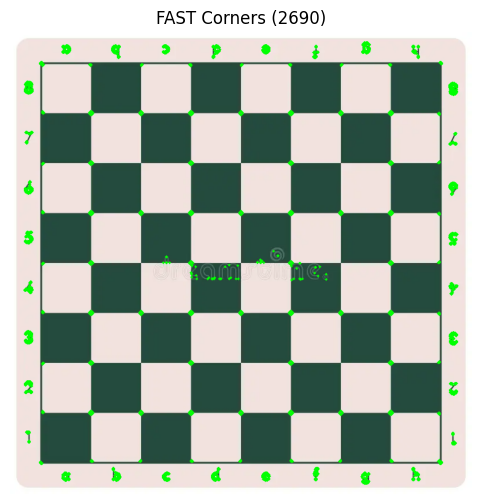

In [ ]:
# Complete FAST corner detector 
import numpy as np
import cv2
import matplotlib.pyplot as plt


# =============================================================================
#                               FAST DETECTOR
# =============================================================================

def fast_corners_from_scratch(gray_img, threshold=25, n=12):
    """
    FAST = Features from Accelerated Segment Test.

    A pixel is a corner if there exist 'n' contiguous pixels on a
    Bresenham circle of radius 3 that are all brighter or darker
    than the center by a threshold.

    Args:
        gray_img : grayscale image (uint8 preferred)
        threshold : intensity difference
        n : contiguous requirement (9 or 12 common)

    Returns:
        list of (y, x)
    """

    # ----------------------------------------------------
    # Ensure uint8
    # ----------------------------------------------------
    if gray_img.dtype != np.uint8:
        gray = gray_img.astype(np.uint8)
    else:
        gray = gray_img.copy()

    h, w = gray.shape
    corners = []

    # ----------------------------------------------------
    # 16 pixel circle (radius = 3)
    # (dy, dx) format
    # ----------------------------------------------------
    circle = [
        (0, 3), (1, 3), (2, 2), (3, 1), (3, 0), (3, -1), (2, -2), (1, -3),
        (0, -3), (-1, -3), (-2, -2), (-3, -1), (-3, 0), (-3, 1), (-2, 2), (-1, 3)
    ]

    # ----------------------------------------------------
    # Avoid borders (need radius = 3)
    # ----------------------------------------------------
    for y in range(3, h - 3):
        for x in range(3, w - 3):

            center = int(gray[y, x])

            # ------------------------------------------------
            # Compare neighbors with center
            # ------------------------------------------------
            flags = []
            for dy, dx in circle:
                p = int(gray[y + dy, x + dx])

                if p > center + threshold:
                    flags.append(1)      # brighter
                elif p < center - threshold:
                    flags.append(-1)     # darker
                else:
                    flags.append(0)      # similar

            # ------------------------------------------------
            # Important: handle circular continuity
            # ------------------------------------------------
            flags = flags + flags

            consec_b = 0
            consec_d = 0
            max_b = 0
            max_d = 0

            for f in flags:
                if f == 1:
                    consec_b += 1
                    consec_d = 0
                elif f == -1:
                    consec_d += 1
                    consec_b = 0
                else:
                    consec_b = 0
                    consec_d = 0

                max_b = max(max_b, consec_b)
                max_d = max(max_d, consec_d)

            # ------------------------------------------------
            # If condition satisfied → corner
            # ------------------------------------------------
            if max_b >= n or max_d >= n:
                corners.append((y, x))

    return corners


# =============================================================================
# Draw helper
# =============================================================================

def draw_corners(image, pts, color=(0, 255, 0)):
    """
    Draw small circles at detected corner locations.
    """
    out = image.copy()

    for y, x in pts:
        cv2.circle(out, (x, y), 2, color, -1)

    return out


# =============================================================================
#                               DEMO
# =============================================================================

def main():

    # ----------------------------------------------------
    # Change path to your image
    # ----------------------------------------------------
    img_path = "chessboard.jpg"

    original = cv2.imread(img_path)

    if original is None:
        print("Error: image not found.")
        return

    # Convert to grayscale
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

    # ----------------------------------------------------
    # Run FAST
    # ----------------------------------------------------
    print("Running FAST detector...")
    pts = fast_corners_from_scratch(
        gray,
        threshold=30,
        n=9
    )

    print("Total FAST corners:", len(pts))

    # ----------------------------------------------------
    # Draw
    # ----------------------------------------------------
    result = draw_corners(original, pts)

    # ----------------------------------------------------
    # Show
    # ----------------------------------------------------
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title(f"FAST Corners ({len(pts)})")
    plt.axis("off")
    plt.show()


# Run as script
if __name__ == "__main__":
    main()


#Compare your implementation speed vs OpenCV on images of different sizes → Create a table / plot: image size vs time (log scale)


In [17]:
#Timing Wrappers
def to_gray(img):
    if len(img.shape) == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def run_ours(detector, img):
    gray = to_gray(img)

    t0 = time.time()

    if detector == "harris":
        pts, _ = harris_corners_from_scratch(gray)
    else:
        pts = fast_corners_from_scratch(gray)

    t1 = time.time()

    return pts, t1 - t0


def run_opencv(detector, img):
    gray = to_gray(img)

    t0 = time.time()

    if detector == "harris":
        cv2.cornerHarris(np.float32(gray), 2, 3, 0.04)
    else:
        fast = cv2.FastFeatureDetector_create()
        fast.detect(gray, None)

    t1 = time.time()

    return None, t1 - t0


In [18]:
IMAGE_PATH = "chessboard.jpg"

img = cv2.imread(IMAGE_PATH)

if img is None:
    print("Image not found")


In [19]:
#Run Pipeline
DETECTOR = "fast"  # change to "harris"

sizes = [128, 256, 512, 768, 1024]

ours_times = []
cv_times = []

for s in sizes:
    small = cv2.resize(img, (s, s))

    _, t1 = run_ours(DETECTOR, small)
    _, t2 = run_opencv(DETECTOR, small)

    ours_times.append(t1)
    cv_times.append(t2)

    print(f"{s}x{s} → ours={t1:.4f}s | opencv={t2:.4f}s")



128x128 → ours=0.1174s | opencv=0.0046s
256x256 → ours=0.4847s | opencv=0.0002s
512x512 → ours=2.0818s | opencv=0.0003s
768x768 → ours=4.8570s | opencv=0.0005s
1024x1024 → ours=8.7900s | opencv=0.0007s


In [21]:
import pandas as pd
#Table
df = pd.DataFrame({
    "Size": sizes,
    "Ours (sec)": ours_times,
    "OpenCV (sec)": cv_times
})

df


,Size,Ours (sec),OpenCV (sec)
0,128,0.117361,0.004565
1,256,0.484687,0.000153
2,512,2.081781,0.000312
3,768,4.856995,0.000504
4,1024,8.790039,0.000709


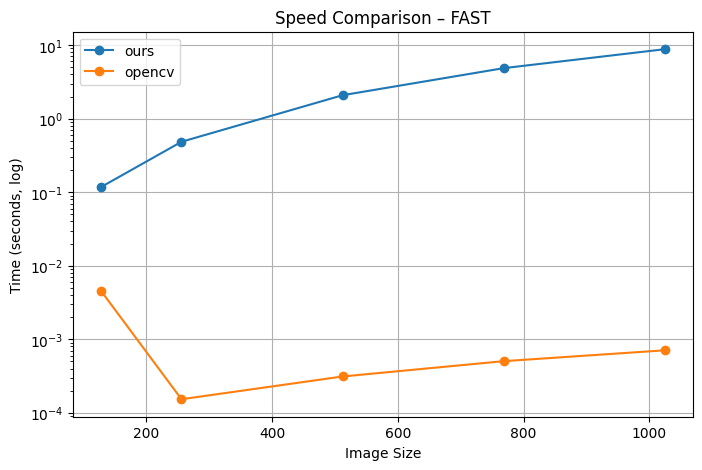

In [22]:
#Log scale plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(sizes, ours_times, marker='o', label="ours")
plt.plot(sizes, cv_times, marker='o', label="opencv")

plt.yscale("log")

plt.xlabel("Image Size")
plt.ylabel("Time (seconds, log)")
plt.title(f"Speed Comparison – {DETECTOR.upper()}")
plt.legend()
plt.grid(True)

plt.show()


What the curves represent

ours → the Python implementation of the FAST
(loops, Python lists, interpreted execution)

opencv → optimized C++ implementation inside OpenCV
(SIMD, cache optimization, early rejection, compiled code)

Y-axis = execution time (log scale)
X-axis = image resolutio